In [26]:
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make plots look nice
sns.set_style("whitegrid")

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Download Apple stock data

In [28]:
# Parameters
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2025-01-01"

# Create data folder
os.makedirs("../data", exist_ok=True)

# Download from Yahoo Finance
data = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Save to CSV
csv_path = f"../data/{TICKER}.csv"
data.to_csv(csv_path)

print(f"Downloaded {len(data)} rows of {TICKER} data and saved to {csv_path}")
# Show first few rows
print(data.head())




/var/folders/vy/q37b89_j7wsfb9b9f0jffx980000gn/T/ipykernel_4341/1367920303.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Downloaded 3774 rows of AAPL data and saved to ../data/AAPL.csv
Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.424605  6.439315  6.375672  6.407193  493729600
2010-01-05  6.435714  6.472039  6.401791  6.442319  601904800
2010-01-06  6.333343  6.461229  6.326738  6.435712  552160000
2010-01-07  6.321635  6.364264  6.275704  6.356759  477131200
2010-01-08  6.363662  6.364263  6.276004  6.313228  447610800


In [29]:
print("Missing values:\n", data.isna().sum())

Missing values:
 Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


### Fix Headers

In [30]:
# Flatten the multi-level columns
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Save clean version
data.to_csv("../data/AAPL.csv")


### Plotting

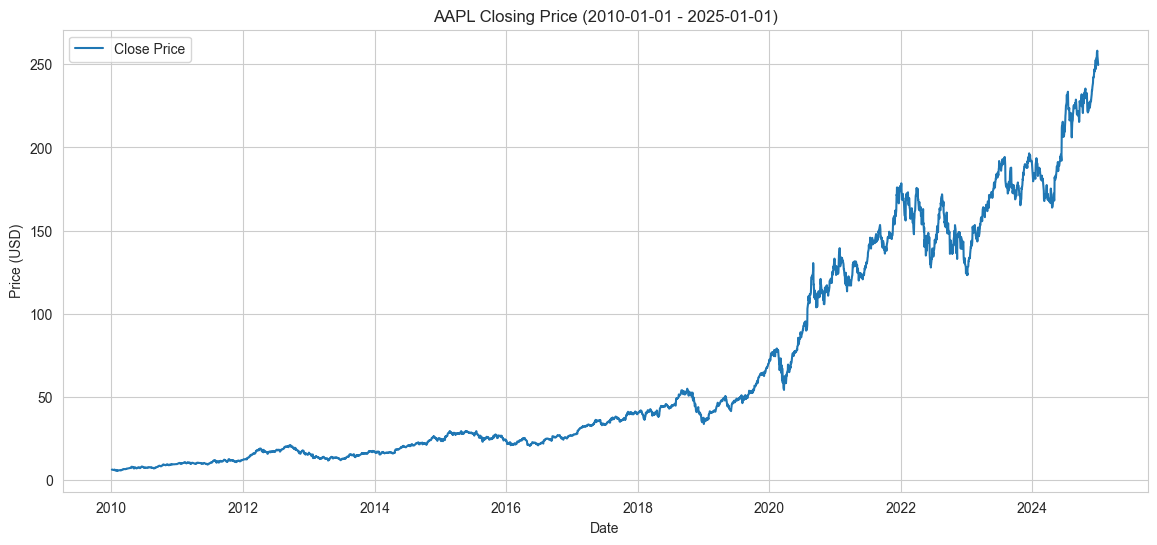

In [31]:
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{TICKER} Closing Price ({START_DATE} - {END_DATE})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## Preprocessing + Sequences

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv("../data/AAPL.csv", parse_dates=["Date"], index_col="Date")

# Use only Close for now (univariate)
close_prices = data[["Close"]]

# Scale to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Train-test split (80/20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences
def create_sequences(dataset, lookback=60):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])  # previous `lookback` closes
        y.append(dataset[i, 0])             # next close
    return np.array(X), np.array(y)

LOOKBACK = 60
X_train, y_train = create_sequences(train_data, LOOKBACK)
X_test, y_test = create_sequences(test_data, LOOKBACK)

# Reshape for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2959, 60, 1) (2959,)
Test shape: (695, 60, 1) (695,)


## Baseline LSTM Model

In [33]:
# ---------------------------
# Model parameters
# ---------------------------
window_size = 60  
features = 1      

# ---------------------------
# Build LSTM model
# ---------------------------
print("Building LSTM model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(window_size, features)))
model.add(Dropout(0.2))
model.add(Dense(1))  # predicting 1 value (next day's close)

model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# Train the model
# ---------------------------
print("Training the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
print("Training complete.")

# ---------------------------
# Make predictions
# ---------------------------
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions complete.")
# ---------------------------
# Evaluate
# ---------------------------
print("Evaluating model...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("Evaluation metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------------------------
# Save predictions for comparison
# ---------------------------
import pandas as pd

pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})
pred_df.to_csv("../data/baseline_lstm_predictions.csv", index=False)
print("Predictions saved to ../data/baseline_lstm_predictions.csv")

Building LSTM model...


/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[21] LSTM-Stock-Price-Prediction/LSTM-Stock-Price-Prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.1677e-04 - val_loss: 5.4607e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.3778e-04 - val_loss: 0.0016
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.9076e-04 - val_loss: 7.8076e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.8769e-04 - val_loss: 0.0024
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.1663e-04 - val_loss: 7.3976e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8147e-04 - val_loss: 4.9669e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.3927e-04 - val_loss: 4.7605e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.5640e-04 - val_loss: 0.0015
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.8098e-04 - val_loss: 0.0010
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.8843e-04 

### Plotting Results

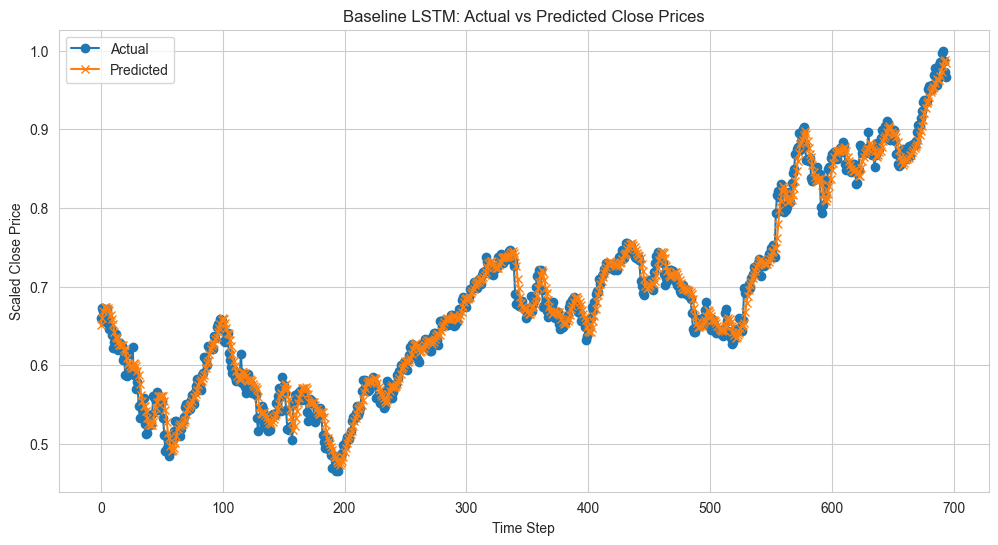

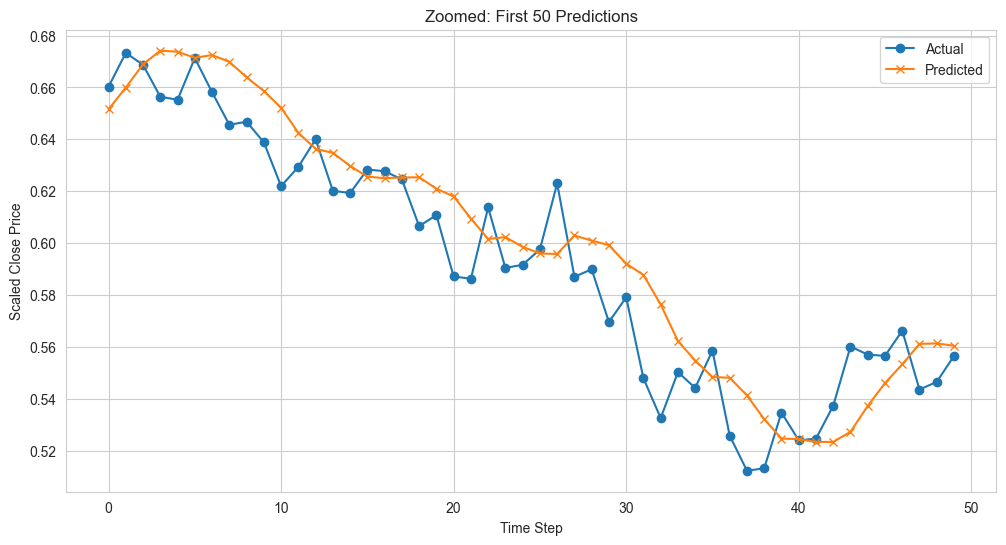

In [34]:
import matplotlib.pyplot as plt

# Assuming pred_df contains your data
plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Predicted'], label='Predicted', marker='x')
plt.title('Baseline LSTM: Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'][:50], label='Actual', marker='o')
plt.plot(pred_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Zoomed: First 50 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()


# Enhanced LSTM Approach

## Stacked LSTM Layers

In [35]:
window_size = 60
features = 1

# Build stacked LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, features)))
model.add(LSTM(units=50, return_sequences=False))  # Last LSTM layer
model.add(Dense(1))  # Predict next day's close

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

print("Training complete.")

# ---------------------------
# Make predictions
# ---------------------------
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions complete.")
# ---------------------------
# Evaluate
# ---------------------------
print("Evaluating model...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("Evaluation metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------------------------
# Save predictions for comparison
# ---------------------------
import pandas as pd

pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})
pred_df.to_csv("../data/layers_lstm_predictions.csv", index=False)
print("Predictions saved to ../data/layers_lstm_predictions.csv")


/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[21] LSTM-Stock-Price-Prediction/LSTM-Stock-Price-Prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.0632e-04 - val_loss: 9.3666e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0005e-04 - val_loss: 0.0011
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.2145e-04 - val_loss: 0.0014
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.4506e-05 - val_loss: 7.5691e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.9388e-05 - val_loss: 7.0805e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.2457e-05 - val_loss: 7.7478e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.0882e-05 - val_loss: 8.7270e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.9692e-05 - val_loss: 5.9600e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 8.3175e-05 - val_loss: 9.6238e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.2486e-05 - val_loss: 9.

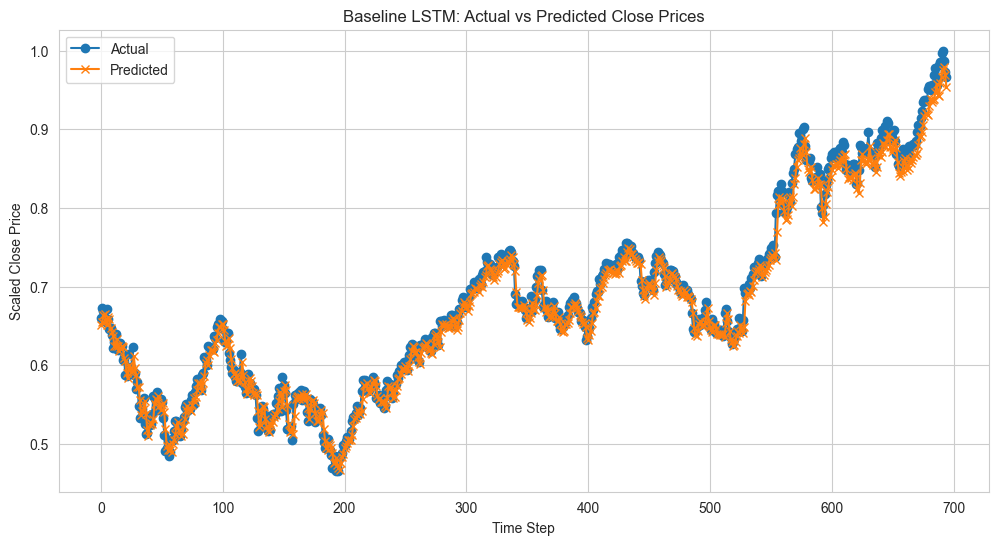

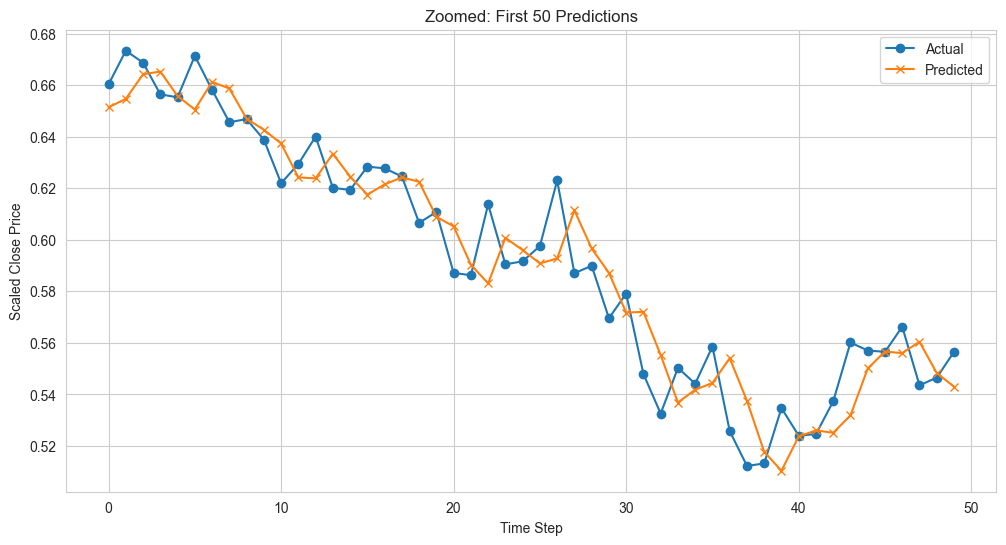

In [36]:
import matplotlib.pyplot as plt

# Assuming pred_df contains your data
plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Predicted'], label='Predicted', marker='x')
plt.title('Baseline LSTM: Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'][:50], label='Actual', marker='o')
plt.plot(pred_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Zoomed: First 50 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()
